# Загрузка библиотек

In [1]:
import os
import json
import torch

import numpy as np

from glob import glob
from transformers import MarkupLMFeatureExtractor, MarkupLMProcessor, MarkupLMForTokenClassification
from bs4 import BeautifulSoup
from torch.utils.data import Dataset, random_split, DataLoader
from tqdm import tqdm

'''
python numpy transformers torch beautifulsoup4 iprogress evaluate seqeval matplotlib ipywidgets lxml

'''

'\npython numpy transformers torch beautifulsoup4 iprogress evaluate seqeval matplotlib ipywidgets lxml\n\n'

# Configuration

In [2]:
classification_model_path = "title_date_tag.pth"
segmentation_model_path = "segmentation_model.pth"

allowed_labels = ["title", "short_text", "date", "time", "tag", "short_title", "author"]


class_label2id = {"OTHER" : 0,
            "title" : 1, 
            "short_text" : 0, 
            "date" : 2, 
            "time" : 2, 
            "tag" : 3, 
            "short_title" : 0, 
            "author" : 0}

class_id2label = {0: "OTHER",
            1 : "title",
            2 : "date",
            3 : "tag"}


block_label2id = {"BEGIN": 1, "OTHER": 0}

block_id2label = {1: "BEGIN", 0: "OTHER"}

# Загрузка данных

In [3]:
def load_from_folder(folder_path : str):
    '''
        This function loading all json files from folder.
        Each file contains dict with labels and its values.
        Each file must contains "html" label with its html code. 
        Each file must contains "xpaths" label with its labeled xpaths list. 
        
    '''
    extractor = MarkupLMFeatureExtractor()
    
    folder_path = os.path.abspath(folder_path)
    files_path = glob(os.path.join(folder_path, "*.json"))
    
    data = []
    
    for file_path in tqdm(files_path):
        # print(file_path)
        with open(file_path) as file:
            info = json.load(file)
            
        html = info["html"]
        labeled_xpaths = info["labeled_xpaths"]
        block_xpaths = info["xpaths"]

        encoding = extractor(html)
            
        
        class_labels = []
        block_labels = []
        for xpath in encoding["xpaths"][0]:
            if xpath in labeled_xpaths.keys():
                class_labels.append(class_label2id[labeled_xpaths[xpath]])
            else:
                class_labels.append(0)
            
            if xpath in block_xpaths:
                block_labels.append(1)
            else:
                block_labels.append(0)
            
        # if (len([_ for _ in labels if _ !=  0]) == 0):
        #     raise Exception("No labeled data found")

        
        class_labels = [class_labels]
        block_labels = [block_labels]
        
        data.append({'nodes': encoding['nodes'],
                     'xpaths': encoding['xpaths'],
                     'class_labels': class_labels,
                     'block_labels': block_labels,
                     'html': html,
                     'block_xpaths' : block_xpaths})
        
    return data
    

In [4]:
train_data = load_from_folder("test_dataset/train_part")
valid_data = load_from_folder("test_dataset/test_part")

100%|██████████| 867/867 [00:33<00:00, 25.73it/s]


In [5]:
print("Train size : ", len(train_data))
print("Test size : ", len(valid_data))
print("Train proportion : ", len(train_data) / (len(valid_data) + len(train_data)))

Train size :  2599
Test size :  867
Train proportion :  0.7498557414887478


In [6]:
idx = 256
for node, label in zip(valid_data[idx]['nodes'][0], valid_data[idx]['class_labels'][0]):
  if class_id2label[label] == 'title':
    print(node, class_id2label[label])
  # print(node, id2label[label])

Jurist Narmin: The number of bankruptcy in Cuba has almost doubled title
Transfer of FF assets as bonds Ukraine will have to respond. title
Jeff Beos is about to sell about 50 million shares of the giant Amazon. title
The analysts discovered what would happen to the ruble, oil and the exchange market until 11 February title
The Wolgograd FAS has entered the " black list " of the pirate company title
In Astrahani, petrol and diesel prices did not change title
Russia will undergo the largest monetary reform since the 1990s. title
More than 11.7 million roubles of maternal capital have been stolen by 27 Australians title
The Etalon Group will trade in the London Exchange before delicting on 6 February title
The Australian region ' s budget increased by 18 billion roubles title
Cliningrades ' savings in banks increased by 25% title
The Antonov analyst called a reason why the dollar would keep it in 95 rubles. title
Income from NDFL increased its share in the Kaliningrad budget by 8.5 per c

# Инициалиация датасета

In [7]:
classification_model = MarkupLMForTokenClassification.from_pretrained("microsoft/markuplm-base", id2label=class_id2label, label2id=class_label2id)
segmentation_model = MarkupLMForTokenClassification.from_pretrained("microsoft/markuplm-base", id2label=block_id2label, label2id=block_label2id)

if os.path.exists(classification_model_path):
    classification_model.load_state_dict(torch.load(classification_model_path))
    print("Classification Model Loaded")
else:
    raise Exception("No model found")


if os.path.exists(segmentation_model_path):
    segmentation_model.load_state_dict(torch.load(segmentation_model_path))
    print("Segmentation Model Loaded")
else:
    raise Exception("No model found")

Some weights of MarkupLMForTokenClassification were not initialized from the model checkpoint at microsoft/markuplm-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of MarkupLMForTokenClassification were not initialized from the model checkpoint at microsoft/markuplm-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Classification Model Loaded
Segmentation Model Loaded


# TEST

In [8]:
import torch
from torch.optim import AdamW
from tqdm.auto import tqdm
from sklearn.metrics import classification_report
from metrics import *
from collections import defaultdict
import re

optimizer = AdamW(classification_model.parameters(), lr=2e-5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

classification_model.to(device)
segmentation_model.to(device)
print(device)

cuda


In [9]:
import sys
sys.setrecursionlimit(100000) 

def intersection_over_union(first_set, second_set):
    inter = first_set.intersection(second_set)
    union = first_set.union(second_set)
    if len(union) == 0:
        return 1
    return len(inter)/len(union)

def similarity(first_entity, second_entity):
    first_title = set()
    second_title = set()

    first_date = set()
    second_date = set()

    first_tag = set()
    second_tag = set()

    for first_xpath, first_label in first_entity.items():
        if first_label == "title":
            first_title.add(first_xpath)
        if first_label == "date":
            first_date.add(first_xpath)
        if first_label == "tag":
            first_tag.add(first_xpath)

    for second_xpath, second_label in second_entity.items(): 
        if second_label == "title":
            second_title.add(second_xpath)
        if second_label == "date":
            second_date.add(second_xpath)
        if second_label == "tag":
            second_tag.add(second_xpath)

    return (intersection_over_union(first_title, second_title) +
            intersection_over_union(first_date, second_date) +
            intersection_over_union(first_tag, second_tag))/3


def match(first_entities, first_idx, second_entities, second_idx):
    if first_idx >= len(first_entities) == 0:
        return (0, [])
    if second_idx >= len(second_entities) == 0:
        return (0, [])

    out1 = similarity(first_entities[first_idx], second_entities[second_idx])
    a_result, a_arr = match(first_entities, first_idx + 1, second_entities, second_idx + 1)
    a_arr = [out1] + a_arr

    out2 = 0
    b_result, b_arr = match(first_entities, first_idx, second_entities, second_idx + 1)

    out3 = 0
    c_result, c_arr = match(first_entities, first_idx + 1, second_entities, second_idx)
    
    if out1 + a_result >= b_result and out1 + a_result >= c_result:
        return (out1 + a_result , a_arr)
    
    if b_result >= out1 + a_result and b_result >= c_result:
        return (b_result, b_arr)
    
    return (c_result, c_arr)

In [10]:
classification_model.eval()
segmentation_model.eval()

valid_processor = MarkupLMProcessor.from_pretrained("microsoft/markuplm-base")
valid_processor.parse_html = False


experiment_results = defaultdict(int)

all_true_results = 0
all_extracted_results = 0
ious = []


confusion_true_label = []
confusion_pred_label = []

for record in tqdm(valid_data):

    item = record
    nodes, xpaths, node_labels = item['nodes'], item['xpaths'], item['block_labels']
    

    block_encoding = valid_processor(nodes=nodes, xpaths=xpaths, stride=0, node_labels=node_labels, 
                               padding="max_length", truncation=True, return_tensors="pt", 
                               return_overflowing_tokens=True, return_offsets_mapping=True)
    
    input = {k:v.to(device) for k,v in block_encoding.items()}
    
    input.pop("overflow_to_sample_mapping")
    offset_mapping = input.pop("offset_mapping")
    labels = input.pop("labels")
    
    with torch.no_grad():
        segmentation_output = segmentation_model(**input)
    segmentation_predictions = segmentation_output.logits.argmax(dim=-1)
    
    # block_xpaths = generate_segmentation_str(item["block_xpaths"])
    
    pred_block_xpaths = []
    true_block_xpaths = []
    
    statistic = {k: defaultdict(int) for k in block_id2label.keys()}
    
    for idx in range(len(segmentation_predictions)):
        for pred_id, word_id, offset, label_id in zip(segmentation_predictions[idx].tolist(), block_encoding.word_ids(idx), offset_mapping[idx].tolist(), labels[idx].tolist()):
            if word_id is not None and offset[0] == 0:
                if pred_id == 1:
                    suffix = xpaths[0][word_id]
                    suffix = re.sub(r"\[\d*\]", "", suffix)
                    statistic[pred_id][suffix] += 1
                    
                    # pred_block_xpaths += [xpaths[0][word_id]]
                if label_id == 1:
                    true_block_xpaths += [xpaths[0][word_id]]
              
    allowed_suffix = dict()
    
    for label in statistic.keys():
        suffix = max(statistic[label], key=statistic[label].get, default="")
        allowed_suffix[suffix] = label
              

    for idx in range(len(segmentation_predictions)):
        for pred_id, word_id, offset, label_id in zip(segmentation_predictions[idx].tolist(), block_encoding.word_ids(idx), offset_mapping[idx].tolist(), labels[idx].tolist()):
            if word_id is not None and offset[0] == 0:
                suffix = xpaths[0][word_id]
                suffix = re.sub(r"\[\d*\]", "", suffix)             
                
                if (suffix in allowed_suffix):
                    pred_block_xpaths += [xpaths[0][word_id]]
        

    pred_block_prefix = generate_segmentation_str(pred_block_xpaths)
    true_block_prefix = generate_segmentation_str(true_block_xpaths)
    # ^^^^^ Main result of segmentation
    
    #CLASSIFICATION
    nodes, xpaths, node_labels = item['nodes'], item['xpaths'], item['class_labels']
    

    class_encoding = valid_processor(nodes=nodes, xpaths=xpaths, stride=0, node_labels=node_labels, 
                               padding="max_length", truncation=True, return_tensors="pt", 
                               return_overflowing_tokens=True, return_offsets_mapping=True)
    
    input = {k:v.to(device) for k,v in class_encoding.items()}
    
    input.pop("overflow_to_sample_mapping")
    offset_mapping = input.pop("offset_mapping")
    labels = input.pop("labels")
    
    with torch.no_grad():
        classification_output = classification_model(**input)
    classification_predictions = classification_output.logits.argmax(dim=-1)
    
    predicted_entities = defaultdict(list)

    out_xpaths = defaultdict(dict)
    
    true_xpaths = defaultdict(dict)
    
    statistic = {k: defaultdict(int) for k in class_id2label.keys()}
    
    
    for idx in range(len(classification_predictions)):
        for pred_id, word_id, offset, label_id in zip(classification_predictions[idx].tolist(), class_encoding.word_ids(idx), offset_mapping[idx].tolist(), labels[idx].tolist()):
            if word_id is not None and offset[0] == 0:
                
                in_predicted_blocks = [path_contains(block_xpath.split('/'), xpaths[0][word_id].split('/')) for block_xpath in pred_block_prefix]

                if pred_id != 0 and any(in_predicted_blocks):
                    # common_suffix = pred_block_prefix[in_predicted_blocks.index(True)].split('/')
                    suffix = xpaths[0][word_id]
                    
                    # for idx, suf1, suf2 in enumerate(zip(common_suffix, suffix)):
                    #     if suf2 != suf1:
                    #         suffix = suffix[idx:]
                    
                    suffix = re.sub(r"\[\d*\]", "", suffix)
                    statistic[pred_id][suffix] += 1
                    
                in_true_blocks = [path_contains(block_xpath.split('/'), xpaths[0][word_id].split('/')) for block_xpath in true_block_prefix]
                if label_id != 0 and any(in_true_blocks):
                    true_xpaths[in_true_blocks.index(True)][xpaths[0][word_id]] = class_id2label[label_id]

                
    
    allowed_suffix = dict()
    
    for label in statistic.keys():
        suffix = max(statistic[label], key=statistic[label].get, default="")
        allowed_suffix[suffix] = label
    # print(allowed_suffix)
    
    
    for idx in range(len(classification_predictions)):
        for pred_id, word_id, offset, label_id in zip(classification_predictions[idx].tolist(), class_encoding.word_ids(idx), offset_mapping[idx].tolist(), labels[idx].tolist()):
            if word_id is not None and offset[0] == 0:
                
                in_predicted_blocks = [path_contains(block_xpath.split('/'), xpaths[0][word_id].split('/')) for block_xpath in pred_block_prefix]

                suffix = re.sub(r"\[\d*\]", "", xpaths[0][word_id])

                if (suffix in allowed_suffix) and any(in_predicted_blocks):
                    # predicted_entities[in_predicted_blocks.index(True)].append({class_id2label[pred_id]: nodes[0][word_id]})
                    # xpath -> label
                    
                    out_xpaths[in_predicted_blocks.index(True)][xpaths[0][word_id]] = class_id2label[allowed_suffix[suffix]]
                    
                    confusion_pred_label.append(pred_id)
                    confusion_true_label.append(label_id)
                    
                elif label_id != 0:
                    confusion_pred_label.append(pred_id)
                    confusion_true_label.append(label_id)
                    
                # if pred_id != 0 and any(in_predicted_blocks) and allowed_suffix[pred_id] == re.sub(r"\[\d*\]", "", xpaths[0][word_id]):
                #     # predicted_entities[in_predicted_blocks.index(True)].append({class_id2label[pred_id]: nodes[0][word_id]})
                #     # xpath -> label
                #     out_xpaths[in_predicted_blocks.index(True)][xpaths[0][word_id]] = class_id2label[pred_id]
                                    
                    
                
    matched = set()

    for ans_idx, answer_entity in true_xpaths.items():
        max_sim = 0
        associated_idx = 0
        for out_idx, out_entity in out_xpaths.items():
            if out_idx in matched:
                continue
            
            sim = similarity(answer_entity, out_entity)
            
            if max_sim < sim:
                max_sim = sim
                associated_idx = out_idx

        matched.add(associated_idx)
        if max_sim > 0:
            ious.append(max_sim)
        
    all_true_results +=  len(true_xpaths)
    all_extracted_results += len(out_xpaths)


  0%|          | 0/867 [00:00<?, ?it/s]

In [11]:
print(ious)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.666666666666

In [12]:
import seaborn as sns 
import matplotlib.pyplot as plt

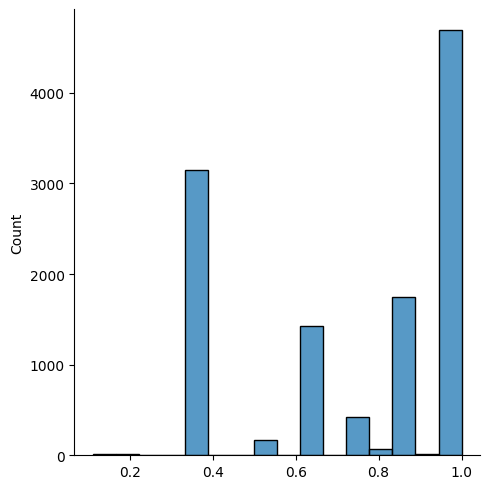

In [13]:
sns.displot(ious)

In [14]:
import numpy as np
import pandas as pd

In [15]:
k = len([i for i in ious if i >= 0.65])
print("Amount of true entities: ", all_true_results)
print("Right extracted entities: ", k)
print("Amount of extracted entities: ", all_extracted_results)
print("Percent of right extracted:", k / all_true_results)

Amount of true entities:  14044
Right extracted entities:  8366
Amount of extracted entities:  16513
Percent of right extracted: 0.5956992309883224


In [16]:
x_points = np.arange(0, 1.01, 0.05)
y_points = [len([i for i in ious if i >= x]) / all_true_results for x in x_points]
data = pd.DataFrame({"percent" : x_points, "IoU" : y_points})
# plt.plot(x_points, y_points, )

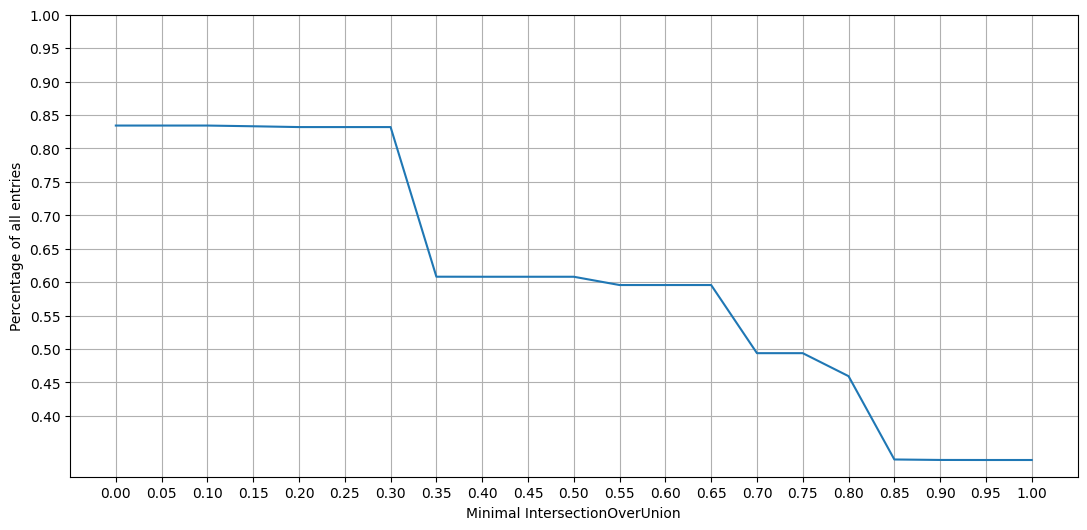

In [17]:
plt.figure(figsize=(13,6))
plt.plot(x_points, y_points)
plt.xticks(x_points, ["{:.2f}".format(a) for a in x_points])
plt.yticks(np.arange(0.4, 1.01, 0.05), ["{:.2f}".format(a) for a in np.arange(0.4, 1.01, 0.05)])
plt.xlabel("Minimal IntersectionOverUnion")
plt.ylabel("Percentage of all entries")
# sns.lineplot(data=data, x="percent", y="IoU")
plt.grid()

In [18]:
recalls = []
precisions = []
print(all_extracted_results)
print(all_true_results)

for threshold in np.arange(0.05, 1.01, 0.05):
    k = len([i for i in ious if i >= threshold])
    TP = k
    FP = all_extracted_results - k
    FN = all_true_results - k

    # print(len(ious))
    Recall = TP/ (TP + FN)
    Precision = TP/ (TP + FP)
    F1 = 2 * (Precision * Recall) / (Precision + Recall)
    
    recalls.append(Recall)
    precisions.append(Precision)


16513
14044


[0.8342352606095129, 0.8342352606095129, 0.8331671888350897, 0.8319567074907434, 0.8319567074907434, 0.8319567074907434, 0.6081600683565935, 0.608088863571632, 0.608088863571632, 0.608088863571632, 0.5956992309883224, 0.5956992309883224, 0.5956992309883224, 0.4938051837083452, 0.46389917402449443, 0.45941327257191683, 0.33480489888920534, 0.33409285103958986, 0.3340216462546283, 0.3340216462546283]
[0.7095016047962212, 0.7095016047962212, 0.7085932295766971, 0.7075637376612366, 0.7075637376612366, 0.7075637376612366, 0.517228849996972, 0.5171682916490038, 0.5171682916490038, 0.5171682916490038, 0.5066311391025253, 0.5066311391025253, 0.5066311391025253, 0.4199721431599346, 0.3945376370132623, 0.3907224610912614, 0.2847453521467934, 0.28413976866711077, 0.2840792103191425, 0.2840792103191425]


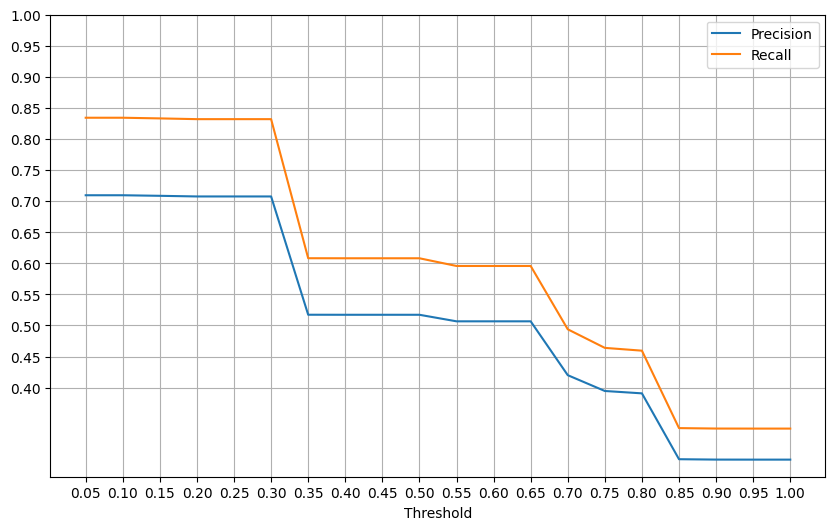

In [19]:
print(recalls)
print(precisions)
plt.figure(figsize=(10, 6))

plt.grid()
plt.plot(np.arange(0.05, 1.01, 0.05), precisions, label="Precision")
plt.plot(np.arange(0.05, 1.01, 0.05), recalls, label="Recall")
plt.xticks(np.arange(0.05, 1.01, 0.05))
plt.yticks(np.arange(0.4, 1.01, 0.05))
plt.legend()
plt.xlabel("Threshold")
plt.show()

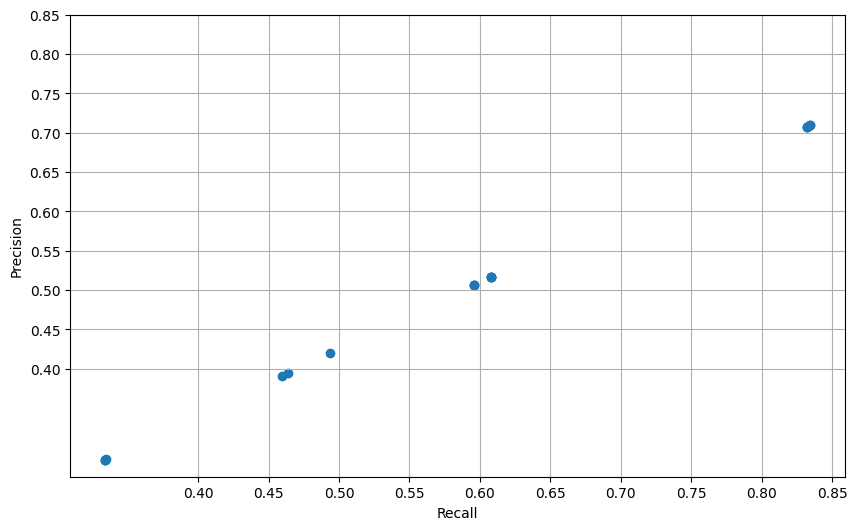

In [20]:
plt.figure(figsize=(10, 6))
plt.grid()
plt.scatter(recalls, precisions)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xticks(np.arange(0.4, 0.9, 0.05))
plt.yticks(np.arange(0.4, 0.9, 0.05))
plt.show()

In [21]:
from sklearn import metrics

y = [1 for i in range(len(ious))]
y += [1 for i in range(all_true_results - len(ious))]

x = ious + [0 for i in range(all_true_results - len(ious))]
fpr, tpr, thresholds = metrics.roc_curve(y, x, pos_label=1)
print(fpr)
print(tpr) 
print(thresholds)

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
[0.         0.33402165 0.33409285 0.3348049  0.45905725 0.45919966
 0.45941327 0.45955568 0.45962689 0.4597693  0.45991171 0.46389917
 0.49380518 0.59569923 0.60808886 0.60816007 0.83195671 0.83316719
 0.83423526 1.        ]
[       inf 1.         0.91666667 0.88888889 0.83333333 0.8125
 0.80769231 0.8        0.7962963  0.79166667 0.77777778 0.77777778
 0.75       0.66666667 0.5        0.35555556 0.33333333 0.16666667
 0.11111111 0.        ]


/home/ubuntu/.cache/pypoetry/virtualenvs/final-experiment-BlrkMlAA-py3.9/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1137: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


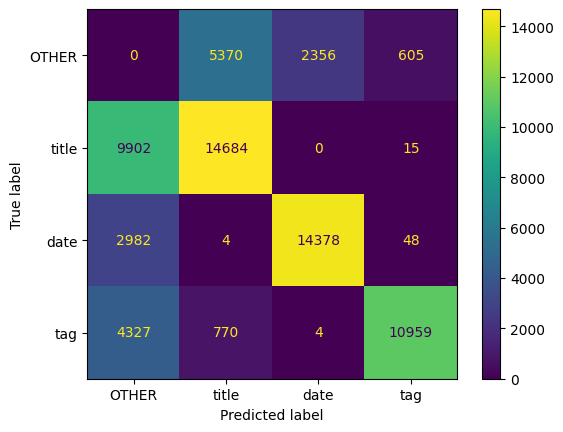

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(confusion_true_label, confusion_pred_label)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_id2label.values())
disp.plot()

plt.show()